# NeuralProphet Library for Forecasting Industrial CO<sub>2</sub> Emission

- https://github.com/ourownstory/neural_prophet/tree/main (Main page github repo)
- https://github.com/ourownstory/neural_prophet/tree/main/docs/source/tutorials (Tutorials)

# Importing Dependecies

In [172]:
#pip install neuralprophet

In [173]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Loading and Preproccessing our Dataset 

**Note:** Whenever you use a dataset with NeuralProphet, it must be a pandas dataframe with the following format and properties:

- Time series column must be named "ds" and contain datetime values.
- Value column must be named "y" and contain float values.

In [174]:
#loading data

df = pd.read_csv('DataSets /WORLD-OWID-Features-Yearly')

In [175]:
df

,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
0,1880-01-01,0.000,853.7050,838.340,256.309556,1814.698707,3100.721,15.364,82.069576
1,1881-01-01,0.000,882.4050,865.162,256.309556,1814.698707,3096.935,17.242,82.069576
2,1882-01-01,0.000,931.9220,912.817,256.309556,0.165000,3159.833,18.939,82.069576
3,1883-01-01,0.000,991.0320,974.149,256.309556,0.381000,3220.534,16.502,82.069576
4,1884-01-01,0.000,1002.1740,982.679,256.309556,1.172000,3240.197,18.323,82.069576
...,...,...,...,...,...,...,...,...,...
137,2017-01-01,1507.923,36096.7380,14506.974,391.992000,7144.928000,4331.947,12242.628,302.294000
138,2018-01-01,1569.218,36826.5080,14746.831,412.116000,7529.847000,4181.356,12266.017,302.479000
139,2019-01-01,1617.507,37082.5590,14725.978,439.254000,7647.528000,4557.283,12345.653,306.639000
140,2020-01-01,1637.537,37103.2055,14174.564,407.584000,7556.290000,4057.758,11191.809,296.302000


In [176]:
df = df[['year', 'co2']]

In [177]:
df.rename(columns = {'year':'ds','co2':'y'}, inplace = True)

WARNING - (py.warnings._showwarnmsg) - /var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_68359/262872096.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [178]:
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')


WARNING - (py.warnings._showwarnmsg) - /var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_68359/1218697604.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [179]:
df

,ds,y
0,1880-01-01,853.7050
1,1881-01-01,882.4050
2,1882-01-01,931.9220
3,1883-01-01,991.0320
4,1884-01-01,1002.1740
...,...,...
137,2017-01-01,36096.7380
138,2018-01-01,36826.5080
139,2019-01-01,37082.5590
140,2020-01-01,37103.2055


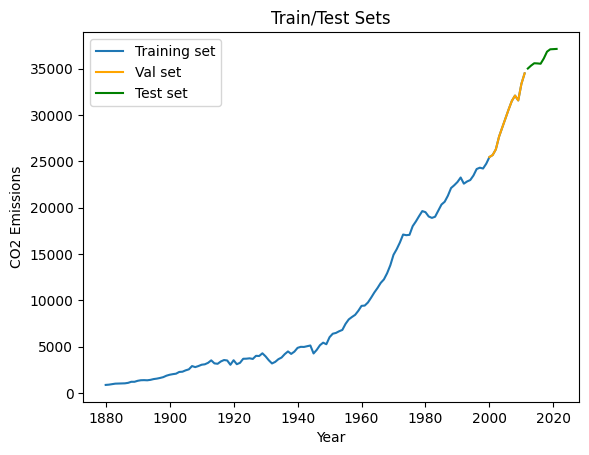

In [180]:
train_set = df[df['ds'] < pd.Timestamp('2012-01-01')]
val_set = df[(df['ds'] >= pd.Timestamp('2000-01-01')) & (df['ds'] < pd.Timestamp('2012-01-01'))]
test_set = df[df['ds'] >= pd.Timestamp('2012-01-01')]

plt.title('Train/Test Sets', size=12)
plt.plot(train_set['ds'], train_set['y'], label='Training set')
plt.plot(val_set['ds'], val_set['y'], label='Val set', color='orange')
plt.plot(test_set['ds'], test_set['y'], label='Test set', color='green')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend();

# Setting up the model

In [181]:
#from pytorch_lightning import Trainer

# Initializing the trainer with MPS 
#trainer = Trainer(accelerator='mps', devices=1)

In [182]:
set_log_level("ERROR")  # Enable logging messages for tips or if there is an error

#m = NeuralProphet(
    #changepoints_range=1,
    #n_forecasts=1,  # Defaults 
    #n_lags=1
#)  
m = NeuralProphet(
    n_lags=1
    # n_changepoints=5,
    #yearly_seasonality=True,
    #weekly_seasonality=True,
    #daily_seasonality=True,
)

# Using static plotly 
m.set_plotting_backend("plotly")

metrics = m.fit(df, freq = 'YS')

WARNING - (py.warnings._showwarnmsg) - /Users/wout_vp/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

# Forecasting on our Val & Test sets 

In [183]:
forecast_val = m.predict(val_set)

Predicting: 9it [00:00, ?it/s]

In [184]:
forecast1 = m.predict(test_set)
forecast1.tail()

Predicting: 9it [00:00, ?it/s]

,ds,y,yhat1,ar1,trend,season_yearly
5,2017-01-01,36096.7380,35939.246094,72.030602,92663.570312,-56796.355469
6,2018-01-01,36826.5080,36457.769531,94.640358,93168.734375,-56805.609375
7,2019-01-01,37082.5590,37055.640625,191.067902,93673.906250,-56809.332031
8,2020-01-01,37103.2055,37461.449219,89.883636,94179.078125,-56807.507812
9,2021-01-01,37123.8520,37778.617188,-110.655113,94685.632812,-56796.355469


# Visualizing + Evaluating the Performance

We will start by visualizing our predictions compared to our actual values to get better insights. 

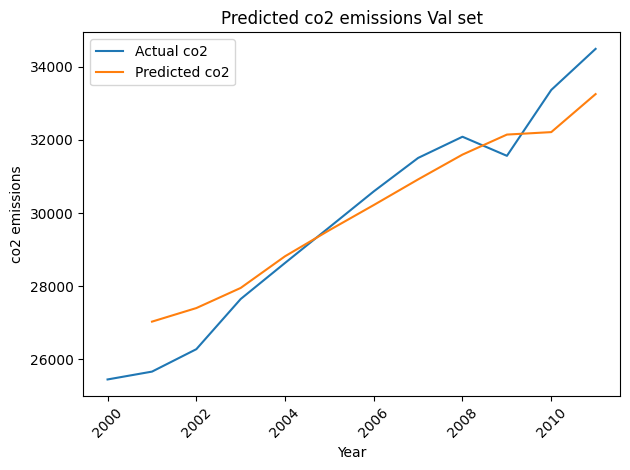

In [185]:
fig, ax = plt.subplots()


ax.plot(forecast_val['ds'], forecast_val['y'], label='Actual co2')
ax.plot(forecast_val['ds'], forecast_val['yhat1'], label='Predicted co2')


ax.set_title('Predicted co2 emissions Val set')
ax.set_xlabel('Year')
ax.set_ylabel('co2 emissions')


ax.legend()


plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

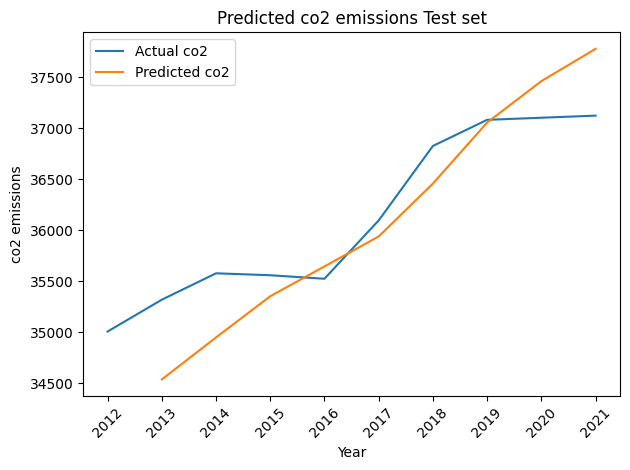

In [186]:
fig, ax = plt.subplots()


ax.plot(forecast1['ds'], forecast1['y'], label='Actual co2')
ax.plot(forecast1['ds'], forecast1['yhat1'], label='Predicted co2')


ax.set_title('Predicted co2 emissions Test set')
ax.set_xlabel('Year')
ax.set_ylabel('co2 emissions')


ax.legend()


plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

Next, we will create/define a simple error_metrics function that takes in our actual values of our preferred test set and calculates the given errors between our actual values and our specified yhat predictions. 

In [187]:
def print_metrics(pred, y_test, model_name):
    mae_ = mean_absolute_error(pred, y_test)
    rmse_ = np.sqrt(mean_squared_error(pred, y_test))
    mape_ = mean_absolute_percentage_error(pred, y_test)
    r2_score_ = r2_score(pred, y_test)

    dict_ = {
        'MAE': mae_,
        'RMSE': rmse_,
        'MAPE': mape_,
        'R2': r2_score_
    }

    metrics = pd.DataFrame(dict_, index=[model_name])

    return metrics.round(decimals=2)

In [188]:
# dropping the laggs/window

true_val_forecast = forecast_val.dropna()
true_forecast = forecast1.dropna()

In [189]:
print_metrics(true_val_forecast['y'], true_val_forecast['yhat1'], "NeuralProphet_Val_set")

,MAE,RMSE,MAPE,R2
NeuralProphet_Val_set,679.17,807.42,0.02,0.91


In [190]:
print_metrics(true_forecast['y'], true_forecast['yhat1'], "NeuralProphet_Test_set")

,MAE,RMSE,MAPE,R2
NeuralProphet_Test_set,367.04,444.98,0.01,0.63


# Forecasting Future Values 

In [191]:
future = m.make_future_dataframe(df, n_historic_predictions=True, periods=5)
forecast = m.predict(future)

Predicting: 9it [00:00, ?it/s]

In [192]:
forecast.tail()

,ds,y,yhat1,ar1,trend,season_yearly
138,2018-01-01,36826.5080,36457.769531,94.640358,93168.734375,-56805.609375
139,2019-01-01,37082.5590,37055.640625,191.067902,93673.906250,-56809.332031
140,2020-01-01,37103.2055,37461.449219,89.883636,94179.078125,-56807.507812
141,2021-01-01,37123.8520,37778.617188,-110.655113,94685.632812,-56796.355469
142,2022-01-01,NaN,38069.578125,-315.609833,95190.796875,-56805.609375


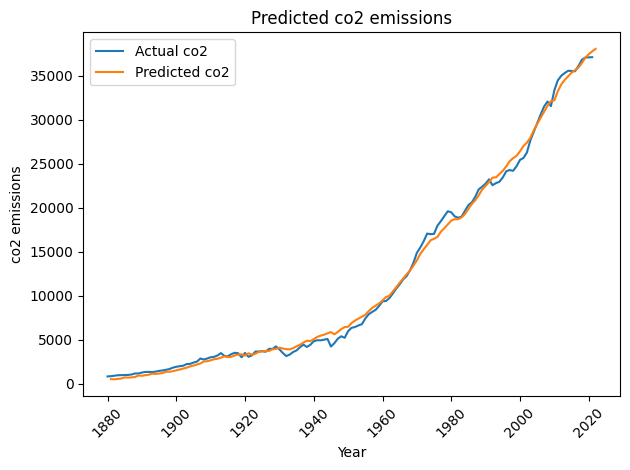

In [193]:
fig, ax = plt.subplots()


ax.plot(forecast['ds'], forecast['y'], label='Actual co2')
ax.plot(forecast['ds'], forecast['yhat1'], label='Predicted co2')


ax.set_title('Predicted co2 emissions')
ax.set_xlabel('Year')
ax.set_ylabel('co2 emissions')


ax.legend()


plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [194]:
m.plot(forecast)

In [195]:
m.plot_components(forecast)

## Next Steps
